In [1]:
filename = "climate/jena_climate_2009_2016.csv"
contents = [ line.strip().split(',') for line in open(filename).readlines()]
header = contents[0]
lines = contents[1:]
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [2]:
lines[0]

['01.01.2009 00:10:00',
 '996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30']

In [3]:
line_fn = lambda line: [ float(v) for i, v in enumerate(line) if i > 0 ]


In [4]:
import numpy as np
# exclude date
matrix = np.zeros((len(lines), len(lines[0]) - 1))
for index, array in enumerate(lines):
    matrix[index, :] = line_fn(array)

In [15]:
matrix


array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

In [16]:
matrix.shape

(420551, 14)

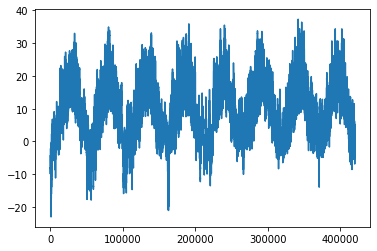

In [6]:
from matplotlib import pyplot as plt

temperature_view = matrix[:, 1]
plt.plot(range(len(temperature_view)), temperature_view, label='Temperature')

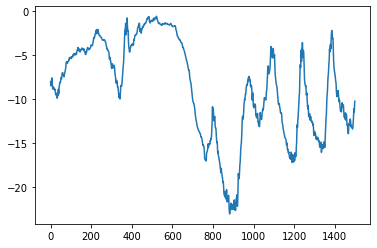

In [7]:
plt.plot(range(1500), matrix[:1500, 1])

In [17]:
 train = matrix[:200000]
 test = matrix[200000:]
 len(train), len(test)

(200000, 220551)

In [18]:
def normalize(matrix: np.array):
    mean = matrix.mean(axis=0)
    stddev = matrix.mean(axis=0)
    return (matrix - mean) / stddev


In [20]:
# train = normalize(matrix[:200000])
mean = matrix[:200000].mean(axis=0)
matrix -= mean
std = matrix[:200000].mean(axis=0)
matrix /= std

In [26]:
def valid(n: int):
    return n is not None

def generator(data, lookback, delay, min_index, max_index=None, shuffle=False, batch_size=128, step=6):
    start = min_index + lookback
    end = max_index if valid(max_index) else (len(data) - delay - 1)

    i = start

    while True:
        # SELECT INDICES
        if shuffle:
            rows = np.random.randint(start, end, size=batch_size)
        else:
            if i + batch_size >= end:
                i = start
            rows = np.arange(i, min(i + batch_size, end))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets


In [41]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(matrix, lookback, delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(matrix, lookback, delay, min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)
test_gen = generator(matrix, lookback, delay, min_index=300001, shuffle=True, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(matrix) - 300001 - lookback)

In [39]:
# It is often useful to have a baseline
# Example if in a binary dataset, 90% data is class A, 10% is class B
# Baseline probability = 0.9
# We create a classifier which outputs classA with 0.9 probability
# any algorithm must have to beat this classifier's accuracy first.
import os
def evaluate_baseline():
    maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        maes.append(
            np.mean(
                np.abs(preds - targets)
            )
        )
        os.system('cls')
        print(step)
    return np.mean(maes)

# too slow
# evaluate_baseline()
baseline = 0.29 # From book

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GRU

model = Sequential()
model.add(Flatten(input_shape=(lookback // step, matrix.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')

In [44]:
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
 16/500 [..............................] - ETA: 6s - loss: 202235346681856.0000

KeyboardInterrupt: 

WEIRD ISSUES, will read from book directly. 